In [1]:
#Set up the notebook environment
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from scipy.io import loadmat, savemat
from scipy.stats import pearsonr
from scipy import signal as sig
from scipy.signal import butter, lfilter, filtfilt, ellip, resample
from scipy.interpolate import CubicSpline

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
# #trying to make a class:
# class data_preparation:
#     ''' '''
#     def __init__(self, raw_training_data, 55

In [2]:
raw_training_data = loadmat('./data/raw_training_data.mat')
leaderboard_data = loadmat('./data/leaderboard_data.mat')

In [3]:
fs = 1000
keylist = list(raw_training_data.keys())
train_data = {'train_dg':[], 'train_ecog':[]}
test_data = {'train_dg':[], 'train_ecog':[]}
for key in keylist[-2:]:
    for i in range(3):
        m,n = np.shape(raw_training_data[key][i][0])
        train_data[key].append(raw_training_data[key][i][0][:int(m/3*2),:])
        test_data[key].append(raw_training_data[key][i][0][int(m/3*2):,:])

print("Number of samples in training set:", np.size(train_data['train_ecog'][0][:,0]))
print("Number of samples in testing set:", np.size(test_data['train_ecog'][0][:,0]))

Number of samples in training set: 200000
Number of samples in testing set: 100000


## Filtering

In [4]:
def freq_domain(X, doplot = False):
    N = len(X)
    n = np.arange(N)
    T = N/200
    freq = n/T 

    # freq = np.fft.fftfreq(N, 1/200)

    sd = np.fft.fft(X)
    if doplot:
        plt.plot(freq, np.abs(sd))
        # plt.xlim([0, 500])
    return [freq, np.abs(sd)]

In [5]:
def filter_data(raw_eeg, fs=1000):
    """
    Write a filter function to clean underlying data.
    Filter type and parameters are up to you. Points will be awarded for reasonable filter type, parameters and application.
    Please note there are many acceptable answers, but make sure you aren't throwing out crucial data or adversly
    distorting the underlying data!

    Input: 
    raw_eeg (samples x channels): the raw signal
    fs: the sampling rate (1000 for this dataset)
    Output: 
    clean_data (samples x channels): the filtered signal
    """

    m,n = np.shape(raw_eeg)

    # Band-pass filter:  
    lowcut = 0.5
    highcut = 200

    b, a = butter(N = 5, Wn = [lowcut, highcut], fs = fs, btype='bandpass')
    y1 = np.stack([filtfilt(b,a, raw_eeg[:,i]) for i in range(n)]) 
    clean_data = y1.T

    # Bandstop filter:   
    bsfreq = np.array([[59, 61], [119, 121], [179, 181]])
    for k in range(np.shape(bsfreq)[0]):
        b1, a1 = butter(N = 4, Wn = bsfreq[k,:], btype = 'bandstop', fs = fs)  
        y2 = np.stack([ filtfilt(b1,a1, clean_data[:,i]) for i in range(n) ])
        clean_data = y2.T

    return clean_data

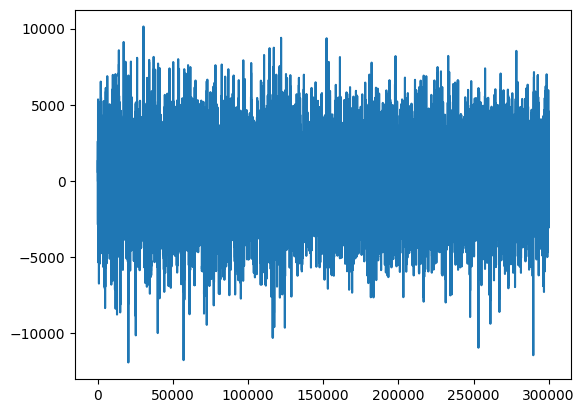

In [6]:
# plt.plot(raw_training_data['train_ecog'][0][0][:,0])
# plt.show()

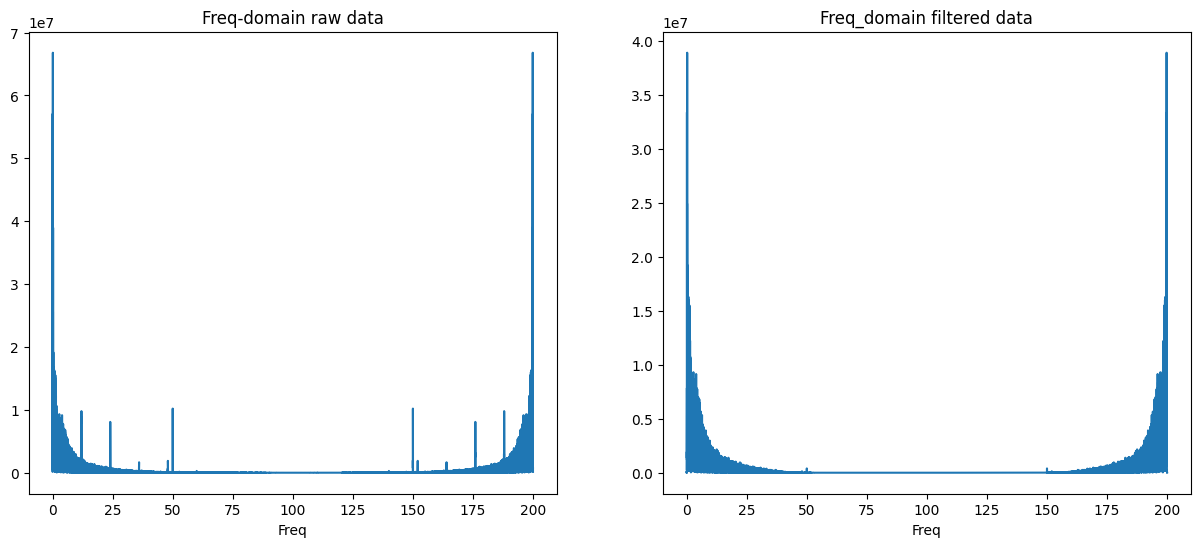

In [7]:
# test filter function
fil_training_0 = filter_data(raw_training_data['train_ecog'][0][0]) # proj_data_filtered
plt.figure(figsize=(15,6))
plt.subplot(121)
freq_domain(raw_training_data['train_ecog'][0][0][:,0], True)
plt.title('Freq-domain raw data')
plt.xlabel('Freq')

plt.subplot(122)
freq_domain(fil_training_0[:,0], True)
plt.title('Freq_domain filtered data')
plt.xlabel('Freq')
plt.show()

In [8]:
# train_fil = {'train_dg':[], 'train_ecog':[]}
# test_fil = {'train_dg':[], 'train_ecog':[]}
# for key in keylist[-2:]:
#     for i in range(3):
#         train_fil[key].append(filter_data(train_data[key][i]))
#         test_fil[key].append(filter_data(test_data[key][i]))

In [9]:
# # filtered data of whole raw_training_data - used for prediction of leaderboard data
# fil_training_data = {'train_dg':[], 'train_ecog':[]}
# for key in keylist[-2:]:
#   for i in range(3):
#     fil_training_data[key].append(filter_data(raw_training_data[key][i][0]))

In [10]:
# ldb_fil = {'leaderboard_ecog':[]}
# for i in range(3):
#     ldb_fil['leaderboard_ecog'].append(filter_data(leaderboard_data['leaderboard_ecog'][i][0]))

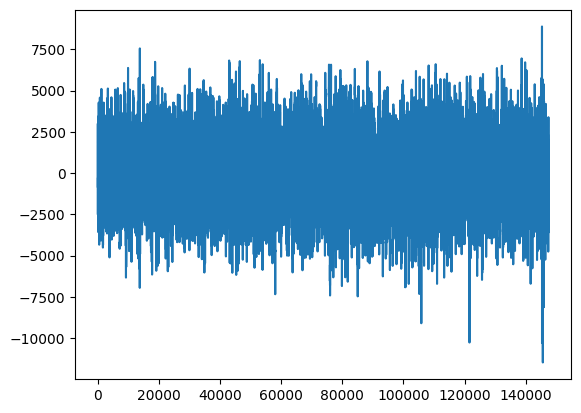

In [11]:
# plt.plot(ldb_fil['leaderboard_ecog'][0][:,0])
# plt.show()

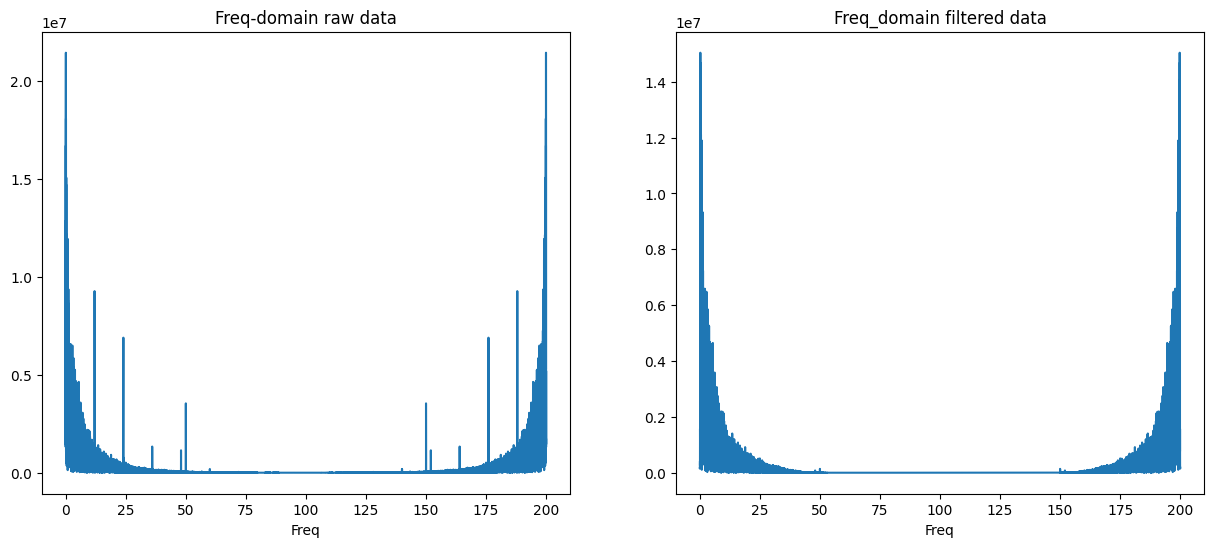

In [12]:
# plt.figure(figsize=(15,6))
# plt.subplot(121)
# freq_domain(leaderboard_data['leaderboard_ecog'][0][0][:,0], True)
# plt.title('Freq-domain raw data')
# plt.xlabel('Freq')

# plt.subplot(122)
# freq_domain(ldb_fil['leaderboard_ecog'][0][:,0], True)
# plt.title('Freq_domain filtered data')
# plt.xlabel('Freq')
# plt.show()

## Calculating features

In [13]:
# Number of windows
def NumWins(x, fs, winLen, winDisp):
    if np.size(np.shape(x)) == 2:
        xLen,_ = np.shape(x)
    else:
        xLen = np.size(x)
    NumWindows = int((xLen - winLen*fs)/(winDisp*fs))+1 # updated from "round((xLen - winLen*fs)/(winDisp*fs))"
    return NumWindows

In [14]:
winlen = 100e-3 # ms
win_overlap = 50e-3
windisp = winlen-win_overlap # ms 

M1 = NumWins(raw_training_data['train_ecog'][0][0], 1000, winlen, windisp)
print("Number of feature windows M is:", M1)

Number of feature windows M is: 5999


In [15]:
def bandpower(data, sf, band, window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.
    Ref: https://raphaelvallat.com/bandpower.html
    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds.
        If None, window_sec = (1 / min(band)) * 2
    relative : boolean
        If True, return the relative power (= divided by the total power of the signal).
        If False (default), return the absolute power.

    Return
    ------
    bp : float
        Absolute or relative band power.
    """
    from scipy.signal import welch
    from scipy.integrate import simps
    band = np.asarray(band)
    low, high = band

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf) #, nperseg=nperseg)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

In [16]:
def get_features(filtered_window, fs=1000):
    """
    Write a function that calculates features for a given filtered window. 
    Feel free to use features you have seen before in this class, features that
    have been used in the literature, or design your own!

    Input: 
      filtered_window (window_samples x channels): the window of the filtered ecog signal 
      fs: sampling rate
    Output:
      features (channels x num_features): the features calculated on each channel for the window
    """
    m,n = np.shape(filtered_window)
    # Average time-domain voltage 
    MeanVol = np.stack([ np.mean(filtered_window[:,i]) for i in range(n) ])

    # Average freq-domain magnitude in several freq bands (kubanek et al, 2009)
    freqbands = np.array([[5,15], [20,25], [75, 115], [125, 160], [160, 175]]) *m/200;
    MeanAmp0 = np.stack([ np.mean(freq_domain(filtered_window[:,i])[1][int(freqbands[0,0]):int(freqbands[0,1])] ) 
      for i in range(n) ])

    MeanAmp1 = np.stack([ np.mean(freq_domain(filtered_window[:,i])[1][int(freqbands[1,0]):int(freqbands[1,1])] ) 
      for i in range(n) ])

    MeanAmp2 = np.stack([ np.mean(freq_domain(filtered_window[:,i])[1][int(freqbands[2,0]):int(freqbands[2,1])] ) 
      for i in range(n) ]) 

    MeanAmp3 = np.stack([ np.mean(freq_domain(filtered_window[:,i])[1][int(freqbands[3,0]):int(freqbands[3,1])] ) 
      for i in range(n) ]) 
    
    MeanAmp4 = np.stack([ np.mean(freq_domain(filtered_window[:,i])[1][int(freqbands[4,0]):int(freqbands[4,1])] ) 
      for i in range(n) ])

    # Bandpower of freq band [0-20 Hz] (warland et al, 1997)
    # BP = np.stack([ bandpower(filtered_window[:,i], sf = 1000, band =[0.5, 20]) for i in range(n) ]) 

    return  np.array([MeanVol, MeanAmp0, MeanAmp1, MeanAmp2, MeanAmp3, MeanAmp4]).T

In [17]:
# test function
winsample = fil_training_0[:int(winlen*1000), :]
featsample = get_features(winsample)
feat_reshape = featsample.T.reshape(-1)

/home/anhtn/.local/lib/python3.8/site-packages/scipy/signal/_spectral_py.py:1961: UserWarning: nperseg = 256 is greater than input length  = 100, using nperseg = 100
  warnings.warn('nperseg = {0:d} is greater than input length '


In [18]:
def get_windowed_feats(raw_ecog, fs, window_length, window_overlap):
    """
    Write a function which processes data through the steps of filtering and
    feature calculation and returns features. Points will be awarded for completing
    each step appropriately (note that if one of the functions you call within this script
    returns a bad output, you won't be double penalized). Note that you will need
    to run the filter_data and get_features functions within this function. 

    Inputs:
      raw_eeg (samples x channels): the raw signal
      fs: the sampling rate (1000 for this dataset)
      window_length: the window's length
      window_overlap: the window's overlap
    Output: 
      all_feats (num_windows x (channels * features)): the features for each channel for each time window
        note that this is a 2D array. 
    """
    window_disp = window_length-window_overlap
    N = NumWins(raw_ecog, fs = fs, winLen = window_length, winDisp = window_disp)

    fil_ecog = filter_data(raw_ecog, fs)

    all_feats = np.array([])
    # for i in range(N):
    #   startwin = int(i*window_disp*fs)
    #   endwin = int(startwin + window_length*fs)
    #   windata = fil_ecog[startwin:endwin,:]

    all_feats = np.stack([ get_features(fil_ecog[int(i*window_disp*fs):int(i*window_disp*fs+ window_length*fs),:], fs).T.reshape(-1) 
    for i in range(N) ])

    return all_feats

In [19]:
# test function
# A = get_windowed_feats(raw_training_data['train_ecog'][0][0], 1000, 100e-3, 50e-3)

Might want to find better features!

## Compute Response matrix
This R matrix is used to resconstruct predicted finger angles (Warland et al 1997) when using linear filter f (linear regression) 
$$ \text{f} = (\textbf{R}^\text{T}\textbf{R})^{-1}(\textbf{R}^\text{T}\textbf{Y})$$

In [20]:
with open('./data/testRfunction.pkl', 'rb') as f1:
    testR_data = pickle.load(f1)

In [21]:
def create_R_matrix(features, N_wind):
    """ 
    Write a function to calculate the R matrix

    Input:
    features (samples (number of windows in the signal) x channels x features): 
      the features you calculated using get_windowed_feats
    N_wind: number of windows to use in the R matrix

    Output:
    R (samples x (N_wind*channels*features))
    """
    M,vf = np.shape(features)
    features_new = np.append(features[:N_wind-1, :].copy(), features, axis=0)

    R = np.stack([ (features_new[i:i+N_wind, :]).reshape(-1) for i in range(M) ])
    R = np.append(np.ones([M,1]), R, axis = 1)

    return R

In [22]:
R_testR = create_R_matrix(testR_data, 3)
np.mean(R_testR)

25.46678519830894

## Linear regression
Linear filter using R matrix (Kubanek et al., 1997)

In [23]:
# # preparing features
# feats_train = []
# feats_test = []
# for k in range(3): #3
#     feats_train.append(get_windowed_feats(train_data['train_ecog'][k], fs, winlen, win_overlap))
#     feats_test.append(get_windowed_feats(test_data['train_ecog'][k], fs, winlen, win_overlap))



In [45]:
df_train = pd.DataFrame({"feats_train" : feats_train})
df_train.to_csv("feats_train.csv")
df_test = pd.DataFrame({"feats_test" : feats_test})
df_test.to_csv("feats_test.csv")

In [24]:
cor=[]
fs = 1000
winlen =  100e-3
win_overlap = 50e-3
predict_dg = []
len_test,_ = np.shape(test_data['train_ecog'][0])
xs = np.arange(0, len_test/fs,1/fs)


for k in range(3): #3
    #downsampling
    M_train,_ = np.shape(feats_train[k])
    M_test,_ = np.shape(feats_test[k])
    Y_train = resample(train_fil['train_dg'][k], M_train)
    Y_test = resample(test_fil['train_dg'][k], M_test)
    # R matrices
    R_train = create_R_matrix(feats_train[k], 3)
    R_test = create_R_matrix(feats_test[k], 3)

    f = np.matmul(np.linalg.inv(np.matmul(R_train.T, R_train)), np.matmul(R_train.T, Y_train))
    Y_hat = np.matmul(R_test, f)
    
        # upsample using cubic spline interpolation
    for finger in range(5):
        x = np.arange(np.size(Y_hat[:,finger]))
        cs = CubicSpline(x, Y_hat[:,finger])
        predict_dg.append(np.array(cs(xs)).T)
    
    cor.append([(pearsonr(test_fil['train_dg'][k][:,i], cs(xs)))[0] for i in range(5)])
    # cor.append([(pearsonr(Y_hat[:,i], Y_test[:,i]))[0] for i in range(5)])

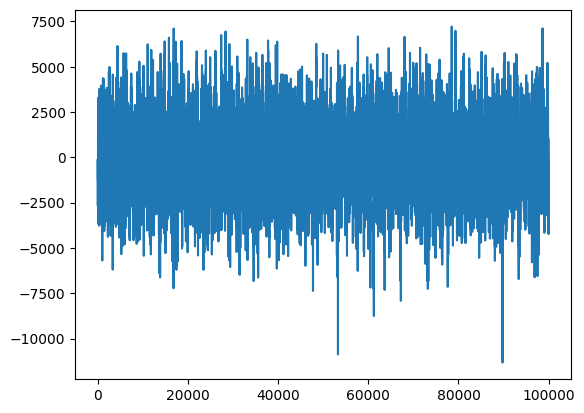

In [25]:
plt.plot(test_fil['train_ecog'][0][:,0])
plt.show()

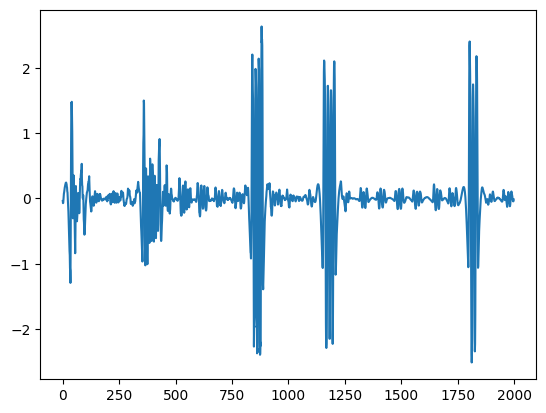

In [26]:
plt.plot(Y_test[:,0])
plt.show()

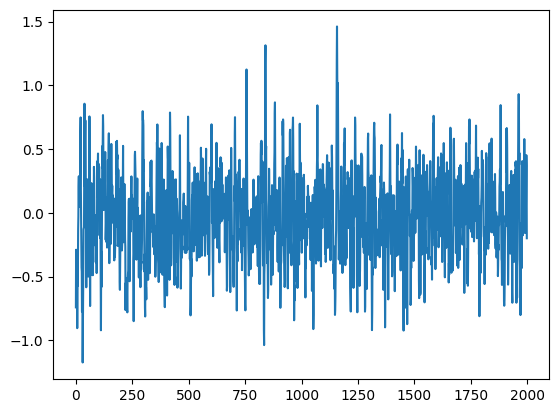

In [27]:
plt.plot(Y_hat[:,0])
plt.show()

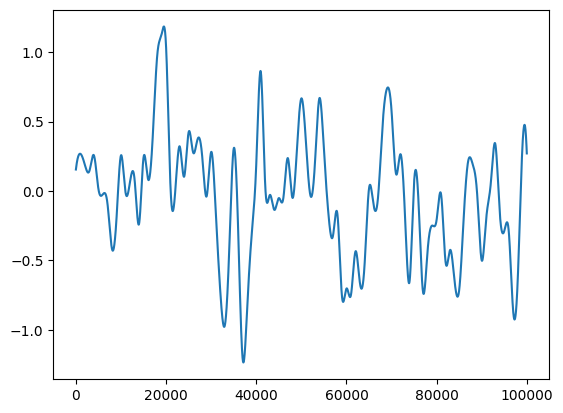

In [28]:
plt.plot(predict_dg[0])
plt.show()

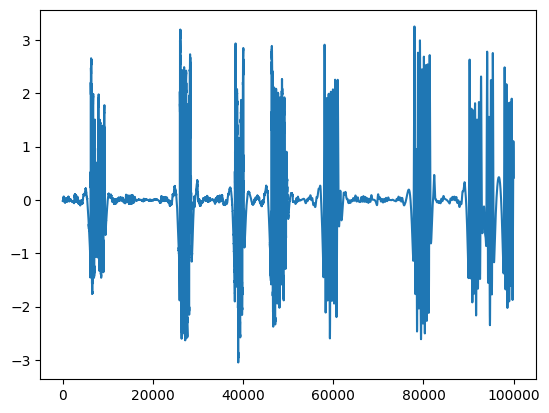

In [29]:
plt.plot(test_fil['train_dg'][0][:,0])
plt.show()

In [30]:
for k in range(3):
    print('From 4.1, Correlation coefficients for 5 fingers of subject', k,':\n', cor[k] )

From 4.1, Correlation coefficients for 5 fingers of subject 0 :
 [0.000518887620584258, 0.0010139562209634215, 0.003727552347197668, 0.0028144910406361387, 0.0015741754901839927]
From 4.1, Correlation coefficients for 5 fingers of subject 1 :
 [-0.0017532784565581615, -0.004756703817890256, -0.0037263551437152994, 2.3025929854336843e-05, -0.0020007238764203875]
From 4.1, Correlation coefficients for 5 fingers of subject 2 :
 [-0.0018774675665787772, 0.0017711027559585636, -0.0015866732533010776, 0.0025039942706628323, 0.004001138609418908]


## Construct prediction for leaderboard data

### Linear regression

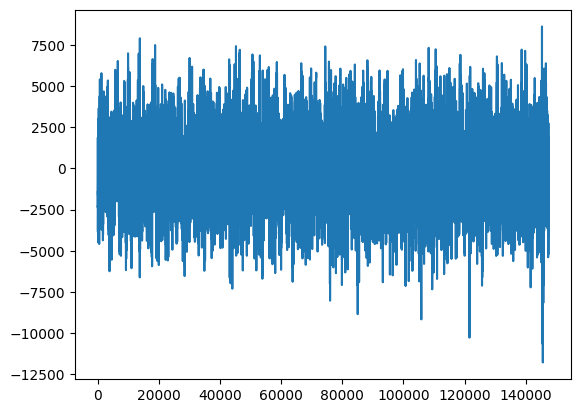

In [31]:
plt.plot(leaderboard_data['leaderboard_ecog'][0][0][:,0])
plt.show()

In [32]:
leaderboard_data['leaderboard_ecog'][0][0][:,0]

array([-2328, -2366, -2129, ..., -1021,  -797,  -761], dtype=int16)

In [33]:
np.shape(leaderboard_data['leaderboard_ecog'][0][0][:,0])

(147500,)

In [34]:
# preparing features
feats_train_whole = []
feats_ldb = []
for k in range(3): #3
    feats_train_whole.append(get_windowed_feats(raw_training_data['train_ecog'][k][0], fs, winlen, win_overlap))
    feats_ldb.append(get_windowed_feats(leaderboard_data['leaderboard_ecog'][k][0], fs, winlen, win_overlap))


/home/anhtn/.local/lib/python3.8/site-packages/scipy/signal/_spectral_py.py:1961: UserWarning: nperseg = 256 is greater than input length  = 100, using nperseg = 100
  warnings.warn('nperseg = {0:d} is greater than input length '


In [44]:
df_train_whole = pd.DataFrame({"feats_train_whole" : feats_train_whole})
df_train_whole.to_csv("feats_train_whole.csv")
df_ldb = pd.DataFrame({"feats_ldb" : feats_ldb})
df_ldb.to_csv("feats_ldb.csv")

In [35]:
def linear_predicted_dg(raw_training_data, leaderboard_data, fil_training_data, feats_train, feats_ldb, fs=1000):
    cor=[]
    fs = 1000
    winlen =  100e-3
    win_overlap = 50e-3
    predict_dg = []
    len_ldb,_ = np.shape(leaderboard_data['leaderboard_ecog'][0][0])

    xs = np.arange(0, len_ldb/fs,1/fs)

    for k in range(3): #3
        #downsampling
        M_train,_ = np.shape(feats_train[k])
        Y_train = resample(fil_training_data['train_dg'][k], M_train)

        # M_ldb,_ = np.shape(feats_test)
        # Y_ldb = resample(test_fil['data_glove'][k], M_ldb)

        # R matrices
        R_train = create_R_matrix(feats_train[k], 3)
        R_ldb = create_R_matrix(feats_ldb[k], 3)

        f = np.matmul(np.linalg.inv(np.matmul(R_train.T, R_train)), np.matmul(R_train.T, Y_train))
        Y_hat = np.matmul(R_ldb, f)

        # upsample using cubic spline interpolation
        for finger in range(5):
            x = np.arange(np.size(Y_hat[:,finger]))
            cs = CubicSpline(x, Y_hat[:,finger])
            predict_dg.append(np.array(cs(xs)).T)
    
    # Contruct predict_dg output
    predict_dg1 = np.reshape(predict_dg, (3,5, len_ldb))
    predict_dg2 = []
    for i in range(3):
        predict_dg2.append(np.array(predict_dg1[i]).T)
    obj = np.zeros((3,1), dtype=object)
    for i in range(3):
        obj[i][0] = predict_dg2[i]
    dic = {"predicted_dg": obj}
    savemat('leaderboard_predicted_dg.mat', dic)  

In [36]:
linear_predicted_dg(raw_training_data, leaderboard_data, fil_training_data, feats_train_whole, feats_ldb, fs=1000)

https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CubicSpline.html

https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.savemat.html

## ML

In [37]:
# prepare labels



In [38]:
# # PCA


# # pca = PCA(n_components = 2)
# fs = 1000
# winlen =  100e-3
# win_overlap = 50e-3
# predict_dg = []
# len_ldb,_ = np.shape(leaderboard_data['leaderboard_ecog'][k][0])
# svm_cor = []

# for k in range(3): #3
#     # feats_train = get_windowed_feats(raw_training_data['train_ecog'][k][0], fs, winlen, win_overlap)
#     # feats_ldb = get_windowed_feats(leaderboard_data['leaderboard_ecog'][k][0], fs, winlen, win_overlap)

#     # data_pca = pca.fit_transform(feats_train)
#     #downsampling
#     M_train,_ = np.shape(feats_train_whole[k])
#     Y_train = resample(fil_training_data['train_dg'][k], M_train)
    
#     #lableling
#     labels_train = np.stack([np.argmax(np.abs(Y_train[i,:])) for i in range(M_train)])
#     # labels_test = np.stack(np.argmax(np.abs(Y_test[i,:])) for i in range(M_test))
#     # ML
#     svm_train = make_pipeline(StandardScaler(), SVC(kernel = 'rbf')).fit(feats_train_whole[k], labels_train)

#     predict = svm_train.predict(feats_ldb[k]) 
#     # svm_cor.append((pearsonr(predict, labels_test))[0])
    
#     print(predict)
    
#     # upsample using cubic spline interpolation
#     for finger in range(5):
#         x = np.arange(np.size(predict))
#         cs = CubicSpline(x, predict)
#         predict_dg.append(cs(xs))

In [39]:
# def predicted_dg_svm(raw_training_data, leaderboard_data, fil_training_data, fil_ feats_train, feats_ldb, fs=1000):
#     winlen =  100e-3
#     win_overlap = 50e-3
#     predict_dg = []
#     len_ldb,_ = np.shape(leaderboard_data['leaderboard_ecog'][0][0])
#     svm_cor = []
    
#     for k in range(1):
        
        
#         #downsampling
#         M_train,_ = np.shape(feats_train[k])
#         Y_train = resample(fil_training_data['train_dg'][k], M_train) #check!!!
        
#         # #lableling
#         # labels_train = np.stack([np.argmax(np.abs(Y_train[i,:])) for i in range(M_train)])
#         # labels_test = np.stack(np.argmax(np.abs(Y_test[i,:])) for i in range(M_test))
        
#         labels_train = 
        
#         # print(np.shape(Y_train))
        
#         # lables_train = 
        
#         for finger in range(1):     
#             # ML
#             svm_train = make_pipeline(StandardScaler(), 
#                                       SVC(kernel = 'rbf')).fit(feats_train[k], Y_train[:,finger].reshape(-1))
#             predict = svm_train.predict(feats_ldb[k]) 
#             print(predict)
        
# #         # upsample using cubic spline interpolation
# #         for finger in range(5):
# #             x = np.arange(np.size(predict))
# #             cs = CubicSpline(x, predict)
# #             predict_dg.append(cs(xs))
            
# #         # Contruct predicted_dg output
# #         predict_dg1 = np.reshape(predict_dg, (3, len_ldb,5))
# #         obj = np.zeros((3,1), dtype=np.object)
# #         for i in range(3):
# #             obj[i][0] = predict_dg1[i,:,:]
# #         dic = {"predicted_dg": obj}
# #         savemat('leaderboard_predict_dg_svm.mat', dic)
#     # return predict

In [40]:
list(raw_training_data.keys())[3:]

['train_dg', 'train_ecog']

In [41]:
# def leaderboard_predicted_dg_svm(train_raw, test_raw, train_fil, test_fil, feats_train, feats_test, fs=1000):
#     winlen =  100e-3
#     win_overlap = 50e-3
#     predicted_dg = []
#     keys_train = list(train_raw.keys())[3:] # keys for raw_training_data: 'train_dg' and 'train_ecog'
#     keys_test = list(test_raw.keys())[3:] # keys for leaderboard_data: 'leaderboard_data'
#     print(keys_test)
#     len_test,_ = np.shape(test_raw[keys_test[0]][0][0])
#     svm_cor = []
#     xs = np.arange(0, len_test/fs,1/fs)
#     print(len_test)
#     for k in range(3): #3 subjects
#         #downsampling of data glove
#         M_train,_ = np.shape(feats_train[k]) # number of samples after downsampling
#         Y_train = resample(train_fil[keys_train[0]][k], M_train)
#         # print(Y_train)
        
#         # #lableling
#         labels_train = get_label_data(Y_train)
#         # labels_train = np.stack([np.argmax(np.abs(Y_train[i,:])) for i in range(M_train)])
#         # print(labels_train)
#         # labels_test will be added later if needed
               
#         # for finger in range(1): #5 fingers
#             # ML
#         svm_train = make_pipeline(StandardScaler(), 
#                                   SVC(kernel = 'rbf')).fit(feats_train[k], labels_train)
#         predict = svm_train.predict(feats_test[k]) 
#         # print(predict)
        
#         predict1 = np.zeros([len(predict), 5])
#         for f in range(5):
#             predict1[:,f] = (predict == f).astype(int)
#         print(np.shape(predict1))
        
#         # upsample using cubic spline interpolation
#         for finger in range(5):
#             x = np.arange(np.size(predict1[:,finger]))
#             cs = CubicSpline(x, predict1[:,finger])
#             predicted_dg.append(cs(xs))
#     print(np.shape(predicted_dg))
        
#     # Contruct predicted_dg output 
# CHANGE THIS
#     predicted_dg1 = np.reshape(predicted_dg, (3, len_test,5))
#     obj = np.zeros((3,1), dtype=np.object)
#     for i in range(3):
#         obj[i][0] = predicted_dg1[i,:,:]
#     dic = {"predicted_dg": obj}
#     savemat('leaderboard_predict_dg_svm.mat', dic)
                                                               
#     # check correlation of split train/test data from raw dataset
#     # if np.size(keys_test) == 2:
#     #     svm_cor.append((pearsonr(predict, labels_test))[0])
                                                               
#     return predicted_dg

In [42]:
def predicted_dg_svm(train_raw, test_raw, train_fil, test_fil, feats_train, feats_test, fs=1000):
    winlen =  100e-3
    win_overlap = 50e-3
    predicted_dg = []
    keys_train = list(train_raw.keys()) # keys for raw_training_data: 'train_dg' and 'train_ecog'
    keys_test = list(test_raw.keys()) # keys for leaderboard_data: 'leaderboard_data'
    print(keys_test)
    len_test,_ = np.shape(test_raw[keys_test[0]][0])
    svm_cor = []
    xs = np.arange(0, len_test/fs,1/fs)
    # print(len_test)
    for k in range(3): #3 subjects
        #downsampling of data glove
        M_train,_ = np.shape(feats_train[k]) # number of samples after downsampling
        Y_train = resample(train_fil[keys_train[0]][k], M_train)
        print('Y', np.shape(Y_train))
        
        # #lableling
        # labels_train = get_label_data(Y_train)
        labels_train = np.stack([np.argmax(np.abs(Y_train[i,:])) for i in range(M_train)])
        print(np.shape(labels_train))
        print(np.shape(feats_train[k]))
        # labels_test will be added later if needed
               
        # for finger in range(1): #5 fingers
            # ML
        svm_train = make_pipeline(StandardScaler(), 
                                  SVC(kernel = 'rbf')).fit(feats_train[k], labels_train)
        predict = svm_train.predict(feats_test[k]) 
        # print(predict)
        # construct the matrix: splitting up the predict into 5 cols for 5 fingers
        predict1 = np.zeros([len(predict), 5])
        for f in range(5):
            predict1[:,f] = (predict == f).astype(int)
        print('predict1', np.shape(predict1))
        
        # upsample using cubic spline interpolation
        for finger in range(5):
            x = np.arange(np.size(predict1[:,finger]))
            cs = CubicSpline(x, predict1[:,finger])
            predicted_dg.append(cs(xs))
    # print('predicted', predicted_dg)
        
    # Contruct predicted_dg output
    predicted_dg1 = np.reshape(predicted_dg, (3,5, len_test))
    predicted_dg2 = []
    for i in range(3):
        predicted_dg2.append(np.array(predicted_dg1[i]).T)
    obj = np.zeros((3,1), dtype=object)
    for i in range(3):
        obj[i][0] = predicted_dg2[i]
    dic = {"predicted_dg": obj}
    savemat('predict_dg_svm.mat', dic)
                                                               
    # check correlation of split train/test data from raw dataset
    # if np.size(keys_test) == 2:
    #     svm_cor.append((pearsonr(predicted, labels_test))[0])
                                                               
    return predicted_dg

In [43]:
def get_label_data(data):  #data has been downsampled
  """
  Inputs: filterd or non-filtered signal glove  from data glove

  Outputs: 1-D array that  has labels from each finger
  """  
  number_finger=5 # number  of fingers to  iterate  over 
    label_matrix=np.zeros([len(data[:,0]),number_finger]) # empty matrix to store the labels spikes from from each finger

    for f in range(number_finger):
        signal=(data[:,f])

        line_avg=np.mean(signal)
        line_std=np.std(signal)

        finger_label=np.zeros(len(signal))

        for i in range(len(signal)):

              if signal[i] > (line_avg+2*line_std):
                    finger_label[i]=f+1


        label_matrix[:,f]=finger_label
        label_array = label_matrix.ravel()

    return label_array

IndentationError: unexpected indent (<ipython-input-43-5899ad6ca022>, line 8)

In [ ]:
# def get_labels(data): #data has been downsampled
#     label_matrix = np.zeros([len(data[:,0]), 5])

#     for f in range(5):
#         signal = data[:,f]

#         line_avg=np.mean(signal)
#         line_std=np.std(signal)

#         finger_label=np.zeros(len(signal))

#         for i in range(len(signal)):

#             if signal[i] > (line_avg+2*line_std):
#                 finger_label[i]=1


#         label_matrix[:,f]=finger_label
#     return label_matrix

In [ ]:
# leaderboard_predicted_dg_svm(raw_training_data, leaderboard_data, fil_training_data, ldb_fil, feats_train_whole, feats_ldb, fs=1000)

In [ ]:
predicted_dg = predicted_dg_svm(train_data, test_data, train_fil, test_fil, feats_train, feats_test, fs=1000)

In [ ]:
plt.plot(test_fil['train_dg'][0][:,0])
plt.show()

In [ ]:
# plt.plot(Y[:,0])
# plt.plot(label)
plt.plot(predicted_dg[0])
plt.show()

In [ ]:
## Cross validation

## Post-processing

In [ ]:
predicted_dg = loadmat('leaderboard_predicted_dg.mat')['predicted_dg']

In [ ]:
np.shape(predicted_dg[0][0])

In [ ]:
plt.plot(predicted_dg[0][0])
plt.show()

In [ ]:
plt.plot(ldb_fil['leaderboard_ecog'][0][:,0])
plt.show()